In [1]:
# Imports

from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import tools
import basilarmembrane
from scipy import signal
import seaborn as sns
import IHC
from cochlea import cochlea


In [2]:
# Load Data

samplerate, data = wavfile.read('audio.wav')

# Discard single channel as we model only one ear in this case
audio = np.array(data[:, 0], dtype=float)
# Signal length in samples
nt = len(audio)

print("Sample rate of audio data: {}".format(samplerate))
print("Length of signal: {} samples".format(nt))
print("Temporal signal duration: {} seconds ({} minutes and {} seconds)"
      .format(nt/samplerate, int((nt/samplerate)//60), (nt/samplerate)%60))

Sample rate of audio data: 44100
Length of signal: 14538287 samples
Temporal signal duration: 329.6663718820862 seconds (5 minutes and 29.666371882086196 seconds)


In [3]:
#Rescale signal between -1 and 1
audio = tools.rescale(audio, -1, 1)


-32768.0 32099.0


In [4]:
# # Plot signal in the time domain
# plt.figure(figsize=(10, 5))
# plt.plot(audio)
# plt.xlabel('Sample n')
# plt.ylabel('Signal Amplitude')
# plt.title('Dave Brubeck - Take Five')

In [5]:
# # Plot signal in the fourier domain
# audio_fft = np.fft.fft(audio)
# audio_fft_freqs = np.fft.fftfreq(nt, 1/samplerate)

# plt.figure(figsize=(20, 5))
# plt.suptitle('Magnitude of fourier transform')
# plt.subplot(1, 2, 1)
# plt.plot(audio_fft_freqs, np.abs(audio_fft))
# plt.xlabel('Freqs (Hz)')
# plt.ylabel('Magnitude')


# plt.subplot(1, 2, 2)
# plt.plot(audio_fft_freqs, np.abs(audio_fft))
# plt.xlim(0, 5000)
# plt.xlabel('Freqs (Hz)')
# plt.ylabel('Magnitude')

In [6]:
# powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(audio, Fs=samplerate)
# plt.xlabel('Time (Seconds)')
# plt.ylabel('Frequency (hZ)')

 

In [7]:
# # Visualise single gammatone filter
# ffilt = 1000
# gammatone1000 = basilarmembrane.gammatone(ffilt, samplerate)
# w, h = signal.freqz(gammatone1000.b, gammatone1000.a, fs=samplerate)

# plt.plot(w, 20 * np.log10(abs(h)))
# plt.xscale('log')
# plt.title('Gammatone filter frequency response')
# plt.xlabel('Frequency')
# plt.ylabel('Amplitude [dB]')
# plt.margins(0, 0.1)
# plt.grid(which='both', axis='both')
# plt.axvline(ffilt, color='green') # cutoff frequency
# plt.show()

In [8]:
# Initialise Model

model = cochlea()
model.set_input(audio, samplerate)

In [9]:
# Generate gammatone basilar membrane filterbank
flims = [200, 4000]
nfilt = 10

#possible basilar membrane filter types:
# gammatone
# transp
model.set_BM('transp', flims, nfilt)




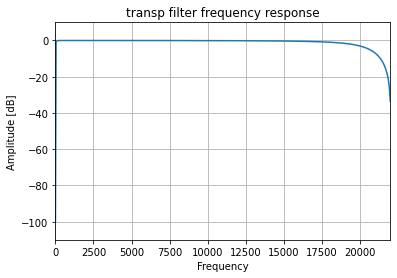

In [10]:
#Plot filters
model.visualise_filters()

14538287
14538287


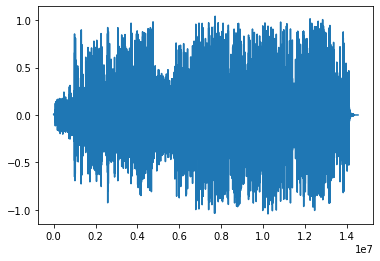

In [11]:
# Filter signal using each band in filterbank (basilar membrane stage 1)
model.filter_bm()
signal_bm = [band['signal_bm'] for band in model.bm['bands'].values()]

print(len(signal_bm[0]))
print(len(audio))
plt.plot(signal_bm[0])
#plt.plot(audio)

In [12]:
# Filter each band using IHC lowpass and half wave rectification (IHC stage 2)
sig_ihc = model.filter_ihc()



IndexError: list index out of range

In [ ]:
# for sig in sig_ihc:
#     plt.plot(sig)
i = 8
signal_ihc = sig_ihc[i]

signal_bm = [band['signal_bm'] for band in model.bm['bands'].values()]
signal_bm = signal_bm[i]

sig_fft_freqs = np.fft.fftfreq(nt, 1/samplerate)

signal_ihc_fft = abs(np.fft.fft(signal_ihc))
signal_bm_fft = abs(np.fft.fft(signal_bm))




In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
plt.xlim([0, 7000])
plt.plot(sig_fft_freqs, signal_bm_fft, label="bm")
plt.subplot(1, 2, 2)
plt.plot(sig_fft_freqs, signal_ihc_fft, label="ihc")
plt.xlim([0, 7000])

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(sig_fft_freqs, signal_bm_fft, label="bm")
plt.xlim([0, 2000])
plt.subplot(1, 2, 2)
plt.plot(sig_fft_freqs, signal_ihc_fft, label="ihc")
plt.xlim([0, 2000])





In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(signal_bm, label="bm")
plt.subplot(1, 2, 2)
plt.plot(signal_ihc, label="ihc")

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(signal_bm[2000:2500], label="bm")
plt.subplot(1, 2, 2)
plt.plot(signal_ihc[2000:2500], label="ihc")
